In [25]:
!pip install astroNN

In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 16 04:48:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    37W / 250W |    629MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
!

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random
random.seed(42)
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
import h5py

from sklearn.model_selection import train_test_split

#loading the file instead of from the model (which is crashing my computer)
import astroNN
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion

In [29]:
#load prre-trained models forr TRRANSFERR learning
#resnet
from keras.applications.resnet_v2 import ResNet101V2

res_model = ResNet101V2()
#res_model.summary()


In [30]:
#learning rate to tune with
from tensorflow.keras.optimizers import SGD, Adam 

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
images, labels = galaxy10.load_data()

/root/.astroNN/datasets/Galaxy10.h5 was found!


In [33]:
labels

array([2, 2, 4, ..., 2, 9, 2], dtype=uint8)

In [34]:
# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
from astroNN.datasets import load_galaxy10 

images, labels = load_galaxy10()

labels

#BEFORE CONVERTING THEM.. THE ORIGINAL DATASET IS IN UINT8 TYPE!!!!
# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

/root/.astroNN/datasets/Galaxy10.h5 was found!


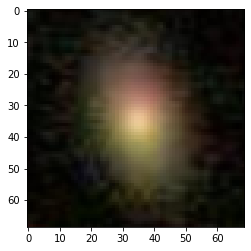

In [35]:
plt.imshow(images[0])

In [36]:
images[0], labels[0]

(array([[[16, 18, 15],
         [18, 20, 15],
         [16, 17, 12],
         ...,
         [ 6,  6,  4],
         [ 9,  9,  7],
         [ 6,  6,  4]],
 
        [[19, 24, 20],
         [23, 25, 20],
         [17, 18, 13],
         ...,
         [ 8,  5,  3],
         [10,  8,  6],
         [ 6,  6,  4]],
 
        [[17, 22, 18],
         [21, 24, 19],
         [17, 18, 13],
         ...,
         [ 8,  4,  3],
         [11,  8,  7],
         [ 7,  6,  4]],
 
        ...,
 
        [[17, 14,  7],
         [18, 17,  9],
         [15, 14,  7],
         ...,
         [ 2,  4,  0],
         [ 3,  5,  0],
         [ 5,  7,  2]],
 
        [[22, 14, 11],
         [19, 14,  8],
         [12,  9,  3],
         ...,
         [ 4,  7,  0],
         [ 6,  9,  2],
         [ 7, 10,  3]],
 
        [[30, 12, 11],
         [31, 14,  8],
         [24,  9,  2],
         ...,
         [ 8, 11,  3],
         [11, 14,  6],
         [12, 15,  7]]], dtype=uint8),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0.

In [37]:
# To convert to desirable type
labels_conv = labels.astype(np.float32)
images_conv = images.astype(np.float32)
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), stratify = labels_conv, test_size=0.1)
                                                        #scale my inputs down to between 0s and 1s
train_images, train_labels, test_images, test_labels = images_conv[train_idx]/255, labels_conv[train_idx], images_conv[test_idx]/255, labels_conv[test_idx]

In [38]:
np.argmax(labels_conv, axis = 1).size

21785

In [39]:
labels_conv

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [40]:
pd.DataFrame(np.argmax(labels_conv, axis = 1)).value_counts(normalize=True) * 100

1    32.118430
2    28.882258
0    15.887078
4     7.041542
7     5.145742
8     4.158825
6     2.703695
9     2.382373
3     1.602020
5     0.078035
dtype: float64

In [41]:
pd.DataFrame(np.argmax(train_labels, axis = 1)).value_counts(normalize=True) * 100

1    32.117719
2    28.884015
0    15.887993
4     7.043762
7     5.146384
8     4.156891
6     2.703254
9     2.381924
3     1.601551
5     0.076507
dtype: float64

In [42]:
#call this function to plot my accuracy/loss against train / test
def plot_hist(hist, metric = "loss"):
    """ plot the results from neural net training 
    
    Args:
        hist (TF history object): The history of the training
        metric (string): The name of the metric to plot (name should be the same as key in hist.history)
    
    Returns: 
        None
    """
    
    plt.figure(figsize=(12, 8))

    plt.plot(hist.history[metric], label=f'Train {metric.capitalize()}')
    plt.plot(hist.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

    plt.title(f'Training & Testing {metric.capitalize()} by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel(metric.capitalize(), fontsize=18)

    plt.legend(fontsize=18);

In [43]:
# load_cnn_layer = load_model("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/cnn_grid_2.h5")

In [44]:
# load_cnn_layer.count_params()

In [45]:
# load_cnn_layer.evaluate(test_images, test_labels)

In [46]:
# load_cnn_layer.layers
#plot_hist(load_cnn_layer. , 'loss')

In [47]:
# reload_base_cnn = load_model("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/base_CNN_model2.h5")
# reload_base_cnn.summary()

In [48]:
# reload_base_cnn.evaluate(test_images, test_labels)

In [49]:
# reload_base_cnn.evaluate

In [50]:
# sample_hist = reload_base_cnn.fit(train_images, train_labels,
#                          batch_size=256, epochs = 100,
#                          validation_data=(test_images, test_labels),
#                          callbacks=EarlyStopping(patience=5))

In [51]:
# plot_hist(sample_hist, 'loss')

In [52]:
# plot_hist(sample_hist, "accuracy")

#**TUNING!**

In [53]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Learning Rate tuning

In [23]:
 def learning_rate_tuning(rate): 
  #Instantiate our CNN model
  cnn_model = Sequential()

  ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape))  #shape of input (one image))
  #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


  #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))
  #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


  #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

  # Add a densely-connected layer with 128 neurons.
  cnn_model.add(Dense(128, activation='relu'))

  # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))

    #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(learning_rate= rate),
                  metrics=['accuracy'])

  return cnn_model

In [24]:
cnn_learning = KerasClassifier(build_fn=learning_rate_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    #'optimizer_f' : [Adam, SGD],
    'rate': [1, 0.1, 0.001, 0.000001]
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [25]:
early_stop = EarlyStopping(patience = 20)
cnn_grid_learning = GridSearchCV(estimator=cnn_learning , param_grid=params, cv=3)
grid_learning = cnn_grid_learning.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks= early_stop)  # call  my early stopping here 

In [26]:
joblib.dump(grid_learning, "/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/tune_learning_jl.h5")

INFO:tensorflow:Assets written to: ram://ee1219c6-6827-41b0-ab16-e833c88ea6d9/assets


['/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/tune_learning_jl.h5']

In [27]:
#grid_learning

In [28]:
cnn_grid_learning.best_estimator_.model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 33, 33, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 7200)              0         
                                                                 
 dense_28 (Dense)            (None, 128)             

In [29]:
cnn_grid_learning.best_params_  #0.1 was the best rate gridsearrched!

{'rate': 0.1}

In [30]:
#best_learning = cnn_grid_learning.best_estimator_

In [31]:
#plot_hist(best_learning.model., 'loss')

#Neurons Tuning!

In [30]:
 def neuron_tuning(neurons): 
  #Instantiate our CNN model
  cnn_model = Sequential()

  ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape))  #shape of input (one image))

  #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

  #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

  #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


  #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

  #recommend putting a dropout layer  (i.e dropout is  a forrm of regularizaiton remember!)

  # Add a densely-connected layer with x neurons.
  cnn_model.add(Dense(neurons, activation='relu'))

  # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))

    #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

  return cnn_model

In [31]:
cnn_neurons = KerasClassifier(build_fn=neuron_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'neurons': [32, 64, 128, 512, 1024, 2048]
    # 'epochs' : [20, 30, 40, 50, 75, 100],
    # 'batch_size': [8, 16, 32, 64, 128, 512, 1024]
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [32]:
early_stop = EarlyStopping(patience = 5)


cnn_grid_neurons = GridSearchCV(estimator=cnn_neurons , param_grid=params, n_jobs= -2,cv=3)
grid_neurons = cnn_grid_neurons.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here 

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [39]:
grid_neurons.best_params_ #2048

{'neurons': 2048}

In [33]:
grid_neurons.best_estimator_.model.history.history['val_loss'][-1]

0.7591003179550171

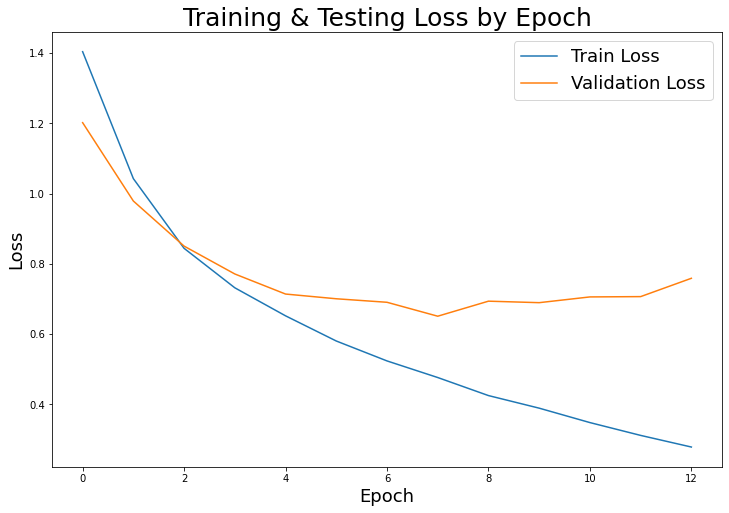

In [34]:
plot_hist(grid_neurons.best_estimator_.model.history, 'loss')
#seeing that it diverges very early in epochs.. put a much muhc smaller LEARNING RATE like 1e^-7

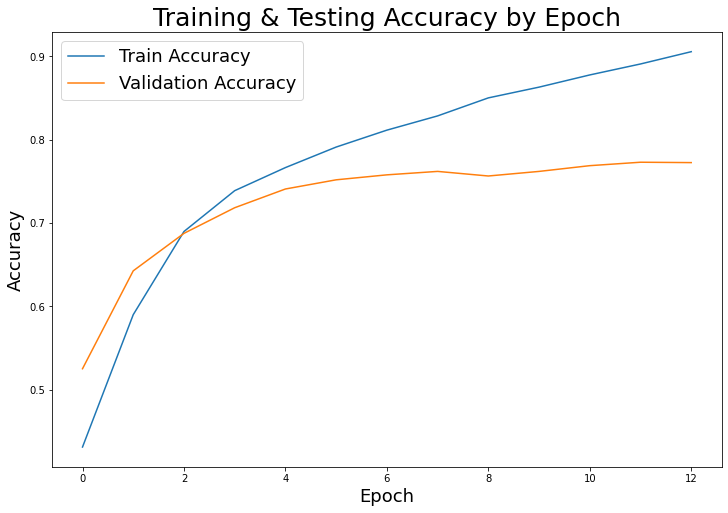

In [35]:
plot_hist(grid_neurons.best_estimator_.model.history, 'accuracy')

In [36]:
type(grid_neurons)

sklearn.model_selection._search.GridSearchCV

In [54]:
grid_neurons.best_estimator_.model.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/neuron_tuning2048.h5')
model_neuron = load_model("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/neuron_tuning2048.h5")

In [ ]:
# plot_hist(model_neuron.history.history, 'accuracy')

In [41]:
#SAVE IT---------------------------------------------
joblib.dump(grid_neurons, "/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/neurons_tuning_jl.h5")

INFO:tensorflow:Assets written to: ram://e6545876-f34e-4236-80ff-e60c4672b6c3/assets


['/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/neurons_tuning_jl.h5']

In [42]:
#grid_results.best_params_
grid_neurons.best_params_  #2048 neurons

{'neurons': 2048}

In [ ]:
# best_neurons = grid_results.best_estimator_
# best_neurons

In [43]:
saved_grid_neurons = joblib.load("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/neurons_tuning_jl.h5")

In [58]:
saved_grid_neurons.best_estimator_.score(test_images, test_labels)

0.7723726630210876

In [45]:
saved_grid_neurons.best_estimator_.sk_params

{'batch_size': 256, 'epochs': 100, 'neurons': 2048, 'verbose': 0}

In [53]:
saved_grid_neurons.best_estimator_.model.history.history.keys()

dict_keys([])

In [ ]:
# plot_hist(cnn_hist, 'loss')

In [ ]:
# plot_hist(cnn_hist, 'accuracy')

In [ ]:
#my model train and test are diverging in earrly epochs

# Layer Tuning




In [59]:
def layer_tuning(conv_layers): #, pooling_layer): 

  #Instantiate our CNN model
  cnn_model = Sequential()

  ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape))  #shape of input (one image))

  #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

  #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

  #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

  if conv_layers > 0:
    while (conv_layers > 0):
      #Add my conv layers
      cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))
      conv_layers = conv_layers - 1


  #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

  # Add a densely-connected layer with 128 neurons.
  cnn_model.add(Dense(128, activation='relu'))

  # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))


  #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

  return cnn_model
    

In [60]:
cnn = KerasClassifier(build_fn=layer_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'conv_layers': [2, 3, 7, 9, 15, 21, 34]
    ## you cna call epoch here:
    #'epoch': [some numbers]
}
#may need to implement a learning rate scheduler... and early stopping
#implement batch normalization (a ftn we add to our layers!) to speed up training time---
# as the model learns more and more we want 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
early_stop = EarlyStopping(patience = 20)
cnn_grid = GridSearchCV(estimator=cnn, param_grid=params, cv=3)
grid_layers = cnn_grid.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here prob


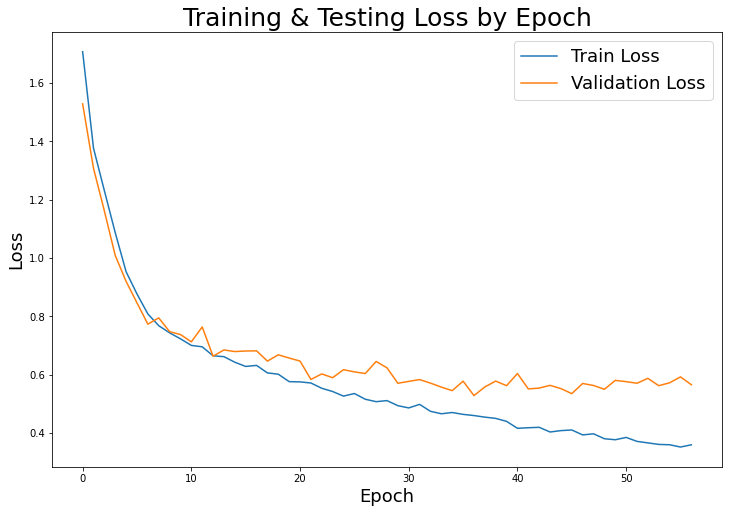

In [69]:
plot_hist(grid_layers.best_estimator_.model.history, 'loss')

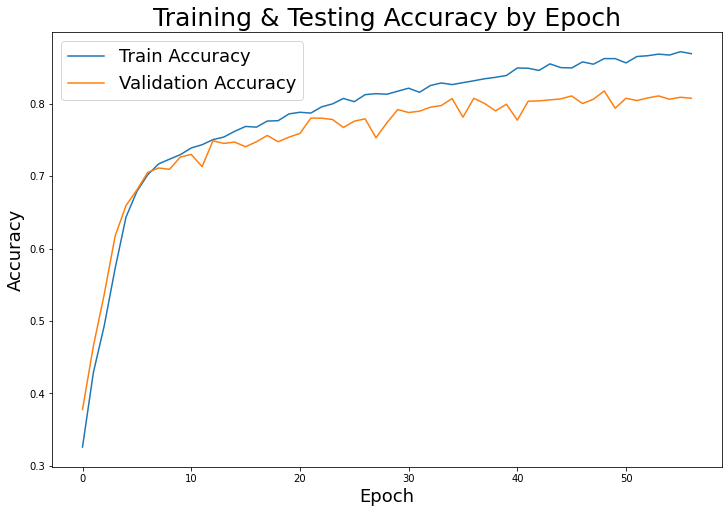

In [70]:
plot_hist(grid_layers.best_estimator_.model.history, 'accuracy')

In [66]:
joblib.dump(grid_layers, "/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/layer_tuning_jl.h5")

INFO:tensorflow:Assets written to: ram://4e312f00-3d6e-44ff-ba7d-06a33fb1009c/assets


['/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/SAVED_MODELS/layer_tuning_jl.h5']

In [65]:
grid_layers.best_params_

{'conv_layers': 7}

In [68]:
grid_layers.best_estimator_.model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_176 (Conv2D)         (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 33, 33, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_177 (Conv2D)         (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_178 (Conv2D)         (None, 13, 13, 32)        9248      
                                                                 
 conv2d_179 (Conv2D)         (None, 11, 11, 32)      

In [ ]:
## 7 convolutional layers added for best added param

# Hidden Layer Tuning

In [105]:
#from keras import activations
def hidden_layer_tuning(hidden_layers): #, pooling_layer): 

  #Instantiate our CNN model
  cnn_model = Sequential()

  ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape))  #shape of input (one image))

  #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

  #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

  #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


  #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

  # Add a densely-connected layer with 128 neurons.
  cnn_model.add(Dense(128, activation='relu'))

  #-----------------
  while ( (hidden_layers-1) != 0):
    
    if (hidden_layers%2 == 0):
      cnn_model.add(Dense(64, activation='relu'))
    else:
      cnn_model.add(Dense(32, activation='relu'))
    hidden_layers = hidden_layers - 1
  #--------------

  # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))


  #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

  return cnn_model

In [106]:
cnn_hidden = KerasClassifier(build_fn=hidden_layer_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'hidden_layers': [2, 3, 7, 9, 15, 21]
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [107]:
early_stop = EarlyStopping(patience = 20)
cnn_grid = GridSearchCV(estimator=cnn_hidden, param_grid=params, cv=3)
grid_layers = cnn_grid.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here prob


In [113]:
grid_layers.best_params_

{'hidden_layers': 2}

In [114]:
grid_layers.best_estimator_.model.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_158 (Conv2D)         (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d_161 (MaxPooli  (None, 33, 33, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_159 (Conv2D)         (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_162 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_79 (Flatten)        (None, 7200)              0         
                                                                 
 dense_273 (Dense)           (None, 128)             

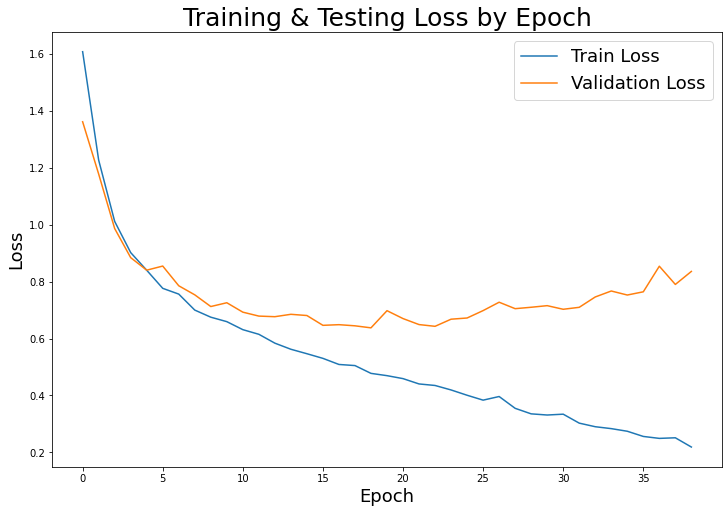

In [108]:
plot_hist(grid_layers.best_estimator_.model.history, 'loss')

In [110]:
grid_layers.best_estimator_.model.history.history['val_loss'][-1]

0.8359469771385193

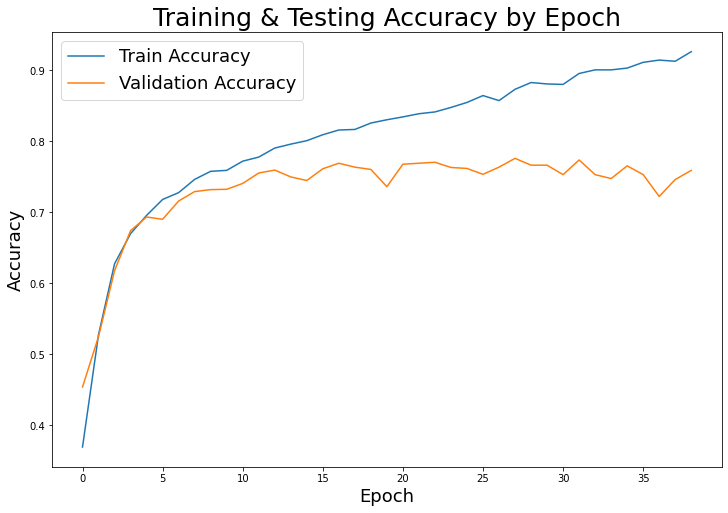

In [109]:
plot_hist(grid_layers.best_estimator_.model.history, 'accuracy')

In [111]:
grid_layers.best_estimator_.model.history.history['val_accuracy'][-1]

0.7590637803077698

#Batch Tuning!

In [72]:

def create_model():
  #Instantiate our CNN model
  cnn_model = Sequential()

    ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape))  #shape of input (one image))

    #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

    #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape )) #shape of input (one image))

    #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


    #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

    #recommend putting a dropout layer  (i.e dropout is  a forrm of regularizaiton remember!)

    # Add a densely-connected layer with x neurons.
  cnn_model.add(Dense(128, activation='relu'))

    # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))

      #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

  return cnn_model

# cnn_model.summary()

In [73]:
# #keras wrapperr
cnn_batch = KerasClassifier(build_fn= create_model, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'batch_size': [8, 16, 32, 64, 128, 512, 1024]
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
early_stop = EarlyStopping(patience = 5)

#Gridsearch
cnn_grid_batch_size = GridSearchCV(estimator=cnn_batch , param_grid=params, n_jobs= -2,cv=3)
grid_batch = cnn_grid_batch_size.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here 

In [77]:
grid_batch.best_params_ # 16

{'batch_size': 16}

In [ ]:
#need to do kernel size, filters, stride

#Kernel Size tuning

In [16]:
def kernel_tuning(kernel):
  #Instantiate our CNN model
  cnn_model = Sequential()

    ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                        kernel_size = kernel,#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape))  #shape of input (one image))

    #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

    #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                        kernel_size = kernel,#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape )) #shape of input (one image))

    #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


    #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

    #recommend putting a dropout layer  (i.e dropout is  a forrm of regularizaiton remember!)

    # Add a densely-connected layer with x neurons.
  cnn_model.add(Dense(128, activation='relu'))

    # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))

      #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

  return cnn_model

In [20]:
# #keras wrapperr
cnn_kernel = KerasClassifier(build_fn= kernel_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'kernel': [(1,1), (2,2), (3,3), (4,4)]
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [21]:
early_stop = EarlyStopping(patience = 5)

#Gridsearch
cnn_grid_kernel = GridSearchCV(estimator=cnn_kernel, param_grid=params, n_jobs= -2,cv=3)
grid_kernel = cnn_grid_kernel.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here 

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [22]:
grid_batch.best_params_   #(4,4)

{'kernel': (4, 4)}

In [23]:
grid_batch.best_score_

0.711107591787974

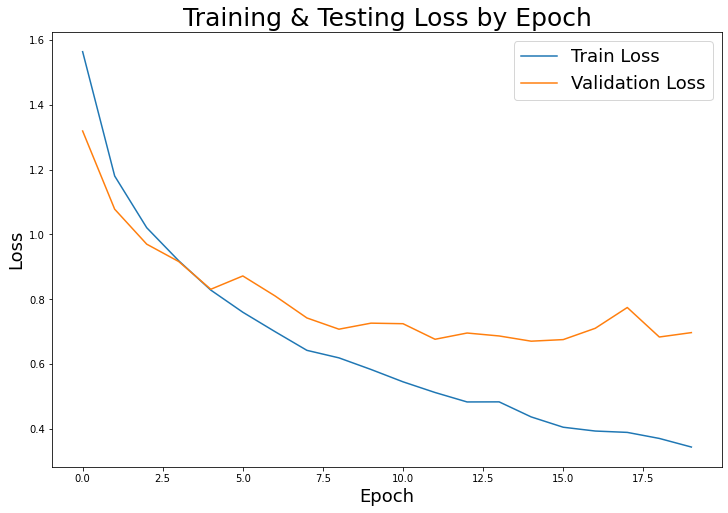

In [26]:
plot_hist(grid_batch.best_estimator_.model.history, 'loss')

In [28]:
grid_batch.best_estimator_.model.history.history['val_loss'][-1]

0.6972635984420776

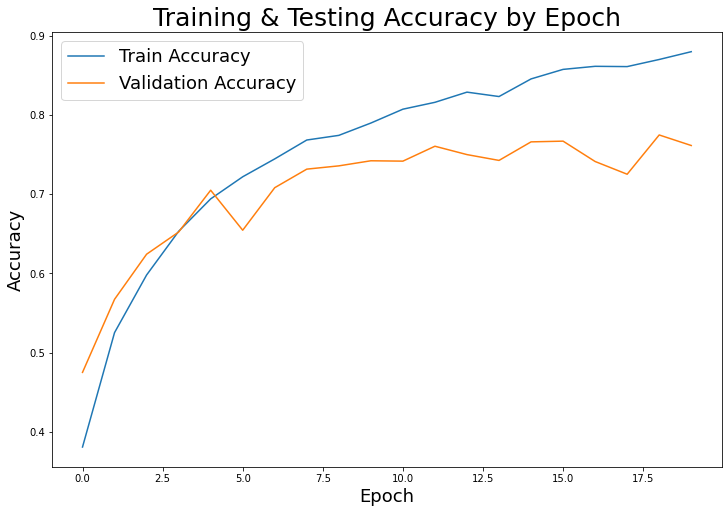

In [27]:
plot_hist(grid_batch.best_estimator_.model.history, 'accuracy')

In [30]:
grid_batch.best_estimator_.model.history.history['val_accuracy'][-1]

0.7613584399223328

# Filter Tuning

In [32]:
def filter_tuning(filter):
  #Instantiate our CNN model
  cnn_model = Sequential()

    ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = filter,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape))  #shape of input (one image))

    #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

    #Add another convolutional layer
  cnn_model.add(Conv2D(filters = filter,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape )) #shape of input (one image))

    #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


    #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

    #recommend putting a dropout layer  (i.e dropout is  a forrm of regularizaiton remember!)

    # Add a densely-connected layer with x neurons.
  cnn_model.add(Dense(128, activation='relu'))

    # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))

      #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

  return cnn_model

In [33]:
# #keras wrapperr
cnn_filter = KerasClassifier(build_fn= filter_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'filter': [8, 16, 32, 64, 128, 256, 512]
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
early_stop = EarlyStopping(patience = 5)

#Gridsearch
cnn_grid_filter = GridSearchCV(estimator=cnn_filter, param_grid=params, n_jobs= -2,cv=3)
grid_filter = cnn_grid_filter.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here 

In [36]:
grid_filter.best_params_

{'filter': 8}

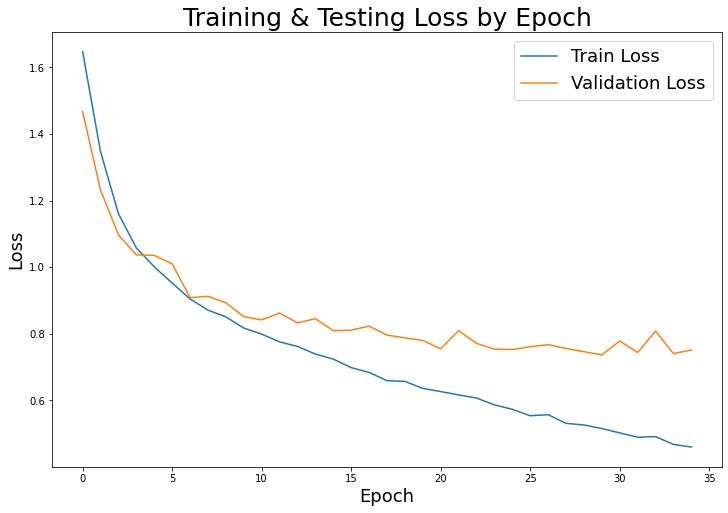

In [37]:
plot_hist(grid_filter.best_estimator_.model.history, 'loss')

In [39]:
grid_filter.best_estimator_.model.history.history['val_loss'][-1]

0.7510101795196533

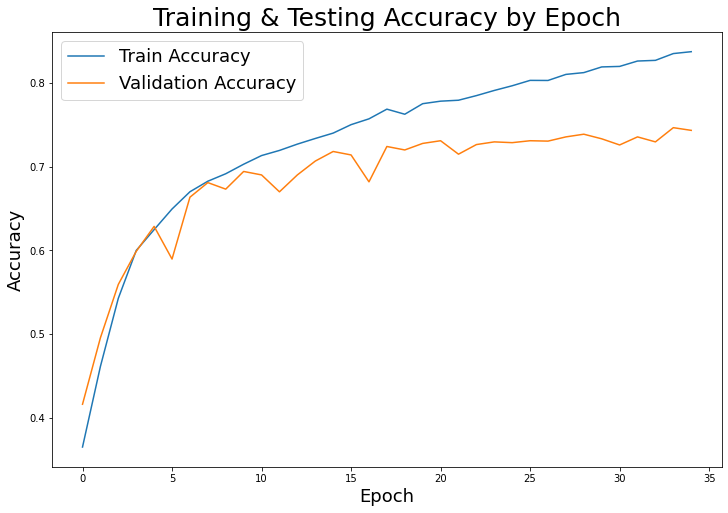

In [38]:
plot_hist(grid_filter.best_estimator_.model.history, 'accuracy')

In [40]:
grid_filter.best_estimator_.model.history.history['val_accuracy'][-1]

0.7434602975845337

# Stride Tuning

In [48]:
def stride_tuning(stride_n):
  #Instantiate our CNN model
  cnn_model = Sequential()

    ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape))  #shape of input (one image))

    #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=stride_n )) #dimensions of region of pooling

    #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape )) #shape of input (one image))

    #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=stride_n)) #dimensions of region of pooling


    #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

    #recommend putting a dropout layer  (i.e dropout is  a forrm of regularizaiton remember!)

    # Add a densely-connected layer with x neurons.
  cnn_model.add(Dense(128, activation='relu'))

    # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))

      #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

  return cnn_model

In [56]:
# #keras wrapperr
cnn_stride = KerasClassifier(build_fn= stride_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'stride_n': [None, 1, 2,3,4,5]
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [57]:
early_stop = EarlyStopping(patience = 5)

#Gridsearch
cnn_grid_stride = GridSearchCV(estimator=cnn_stride, param_grid=params, n_jobs= -2,cv=3)
grid_stride = cnn_grid_stride.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here 

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packag

In [51]:
grid_stride.best_params_

{'stride_n': 4}

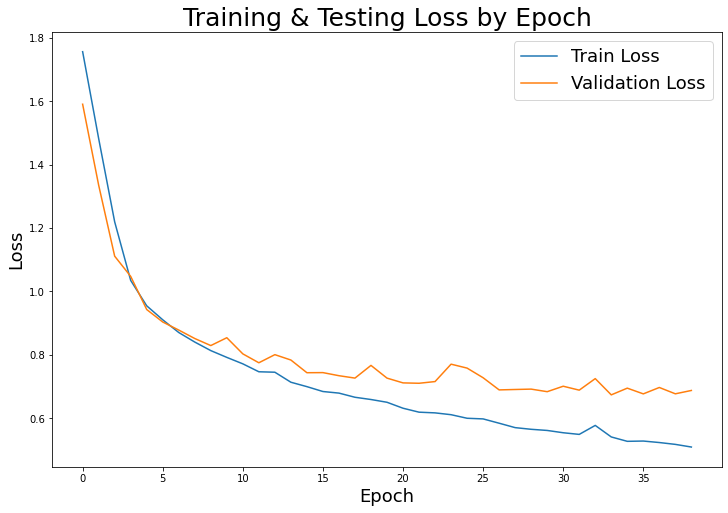

In [52]:
plot_hist(grid_stride.best_estimator_.model.history, 'loss')

In [54]:
grid_stride.best_estimator_.model.history.history['val_loss'][-1]

0.6876124143600464

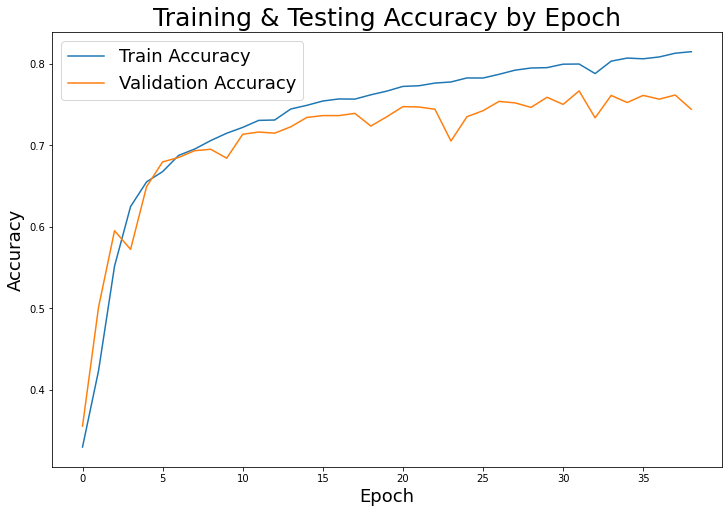

In [53]:
plot_hist(grid_stride.best_estimator_.model.history, 'accuracy')

In [55]:
grid_stride.best_estimator_.model.history.history['val_accuracy'][-1]

0.7443781495094299

## **Regularization**

In [54]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Dropout

In [116]:
def dropout_tuning(drop_n, drop_n2):
  #Instantiate our CNN model
  cnn_model = Sequential()

    ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape))  #shape of input (one image))

    #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2) )) #dimensions of region of pooling

    #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape )) #shape of input (one image))

    #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


    #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

    #recommend putting a dropout layer  (i.e dropout is  a forrm of regularizaiton remember!)




    # Add a densely-connected layer with x neurons.
  cnn_model.add(Dense(128, activation='relu'))

  #--- DROPOUT LAYER----------------------
  cnn_model.add(Dropout(drop_n))

  
  
  cnn_model.add(Dense(128, activation = 'relu'))

  #---- DROPOUT LAYER-----------------------------
  cnn_model.add(Dropout(drop_n2))


    # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))

      #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

  return cnn_model

In [117]:
# #keras wrapperr
cnn_drop = KerasClassifier(build_fn= dropout_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'drop_n': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    'drop_n2': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
early_stop = EarlyStopping(patience = 5)

#Gridsearch
cnn_grid_drop = GridSearchCV(estimator=cnn_drop, param_grid=params, n_jobs= -2,cv=3)
grid_drop = cnn_grid_drop.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here 

In [119]:
grid_drop.best_params_

{'drop_n': 0.15, 'drop_n2': 0.25}

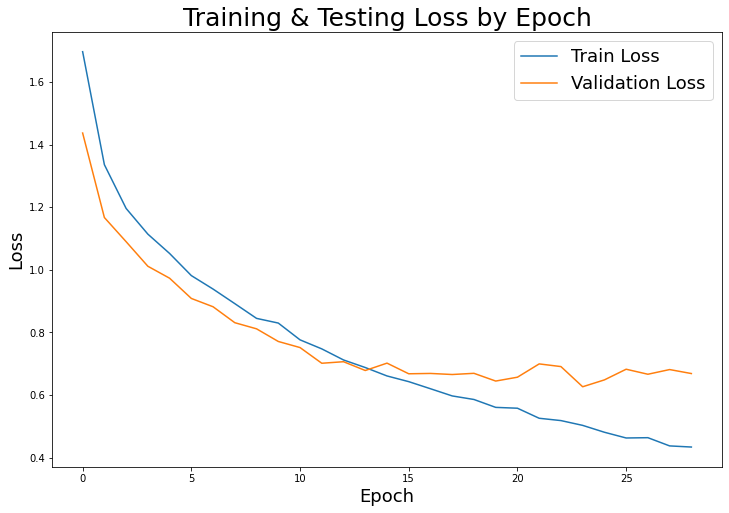

In [120]:
plot_hist(grid_drop.best_estimator_.model.history, 'loss')

In [122]:
grid_drop.best_estimator_.model.history.history['val_loss'][-1]

0.6683555841445923

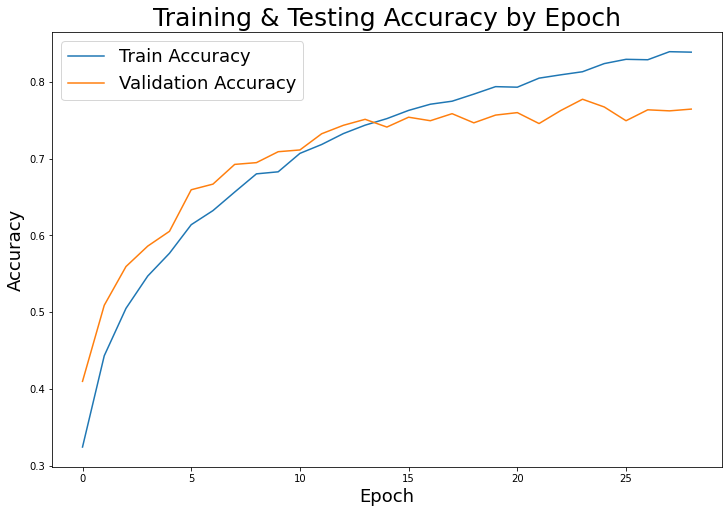

In [121]:
plot_hist(grid_drop.best_estimator_.model.history, 'accuracy')

In [123]:
grid_drop.best_estimator_.model.history.history['val_accuracy'][-1]

0.7645708918571472

# l1 and l2 

In [55]:
def l1_l2_tuning(first_choice, tune1, second_choice, tune2):
  #Instantiate our CNN model
  cnn_model = Sequential()

    ##Add a convolutional layer
  cnn_model.add(Conv2D(filters = 16,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape))  #shape of input (one image))

    #Add a MaxPooling2D layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2) )) #dimensions of region of pooling

    #Add another convolutional layer
  cnn_model.add(Conv2D(filters = 32,  #number of filters
                        kernel_size = (3,3),#height/width of filters
                        activation = 'relu', #activation ftn
                        input_shape = train_images[0].shape )) #shape of input (one image))

    #Add another pooling layer
  cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


    #remember to flatten to go from the matrix (box) to the vertical line of nodes!
  cnn_model.add(Flatten())

    #recommend putting a dropout layer  (i.e dropout is  a forrm of regularizaiton remember!)



  #Choice if first hidden layer is l1 or l2 regularized----
  if first_choice == 'l1':
    cnn_model.add(Dense(128, activation='relu', kernel_regularizer = l1(l1= tune1) ))
  elif first_choice == 'l2':
    cnn_model.add(Dense(128, activation='relu', kernel_regularizer = l2(l2= tune1) ))
  else: #first_choice == 'l1_l2'
    cnn_model.add(Dense(128, activation='relu', kernel_regularizer = l1_l2(l1_l2= tune1) ))

  

  #choices for 2nd hidden layer...
  if second_choice == 'l1':
    cnn_model.add(Dense(64, activation='relu', kernel_regularizer = l1(l1= tune2) ))
  elif second_choice == 'l2':
    cnn_model.add(Dense(64, activation='relu', kernel_regularizer = l2(l2= tune2) ))
  else: #second_choice == 'l1_l2'
    cnn_model.add(Dense(64, activation='relu', kernel_regularizer = l1_l2(l1_l2= tune2) ))

    # Add a final layer with 10 neurons.
  cnn_model.add(Dense(10, activation='softmax'))

      #compile the model
  cnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

  return cnn_model

In [56]:
# #keras wrapperr
cnn_l = KerasClassifier(build_fn= l1_l2_tuning, epochs = 100, batch_size = 256, verbose = 0)

params = {
    'first_choice' : ['l1', 'l2', 'l1_l2'],
    'tune1': [0.15, 0.2, 0.25],
    'second_choice' : ['l1', 'l2', 'l1_l2'],
    'tune2': [0.1, 0.2]
    
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [57]:
early_stop = EarlyStopping(patience = 5)

#Gridsearch
cnn_grid_l = GridSearchCV(estimator=cnn_l, param_grid=params, n_jobs= -2,cv=3)
grid_l = cnn_grid_l.fit(train_images, train_labels, 
             validation_data = (test_images, test_labels),
             callbacks=[early_stop])  # call  my early stopping here 

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pac

In [58]:
grid_l.best_params_

{'first_choice': 'l2', 'second_choice': 'l2', 'tune1': 0.15, 'tune2': 0.2}

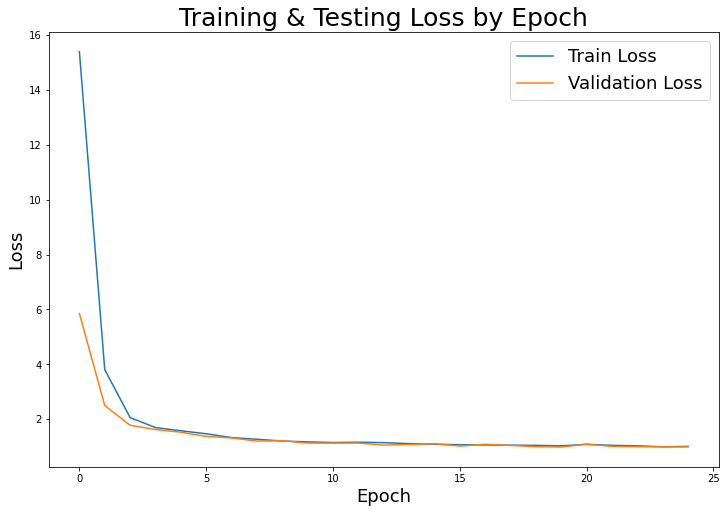

In [59]:
plot_hist(grid_l.best_estimator_.model.history, 'loss')

In [60]:
grid_l.best_estimator_.model.history.history['val_loss'][-1]

0.9868277311325073

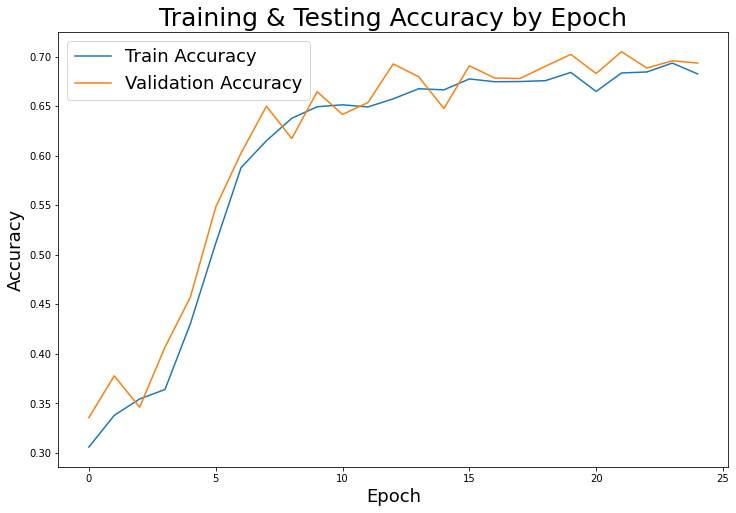

In [61]:
plot_hist(grid_l.best_estimator_.model.history, 'accuracy')

In [62]:
grid_l.best_estimator_.model.history.history['val_accuracy'][-1]

0.6934373378753662